In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import pickle

## Read, scale, and prepare data

In [3]:
def init_datasets(group, test_size = 0.3):

    df = pd.read_csv(f'../Data_processing/output_data/group{group}_df.csv')
    df = df.drop(['ideal_ICU', 
                  'first_category',
                  'index',
                  'INTIME', 
                  'OUTTIME_COLLAPSED'], axis=1)
    train, test_unseen = train_test_split(df, test_size=test_size, random_state=42)
    unseen, test = train_test_split(test_unseen, test_size=test_size, random_state=42)
    return (train, test, unseen)


In [4]:
y_col = ['los_icu']

categorical_variables = ['gender', 'ethnicity_grouped', 'admission_type', 'first_hosp_stay','first_icu_stay', 'age_group', 'dod_exists',
   'sepsis', 'INTIME_COLLAPSED_day', 'FIRST_CAREUNIT']

numerical_variables = init_datasets(group=1)[0][init_datasets(group=1)[0].columns.difference(categorical_variables + y_col)].columns


In [5]:
def get_x_y(train, test, unseen):
    #X and y for train and test
    X = train.drop(['los_icu'], axis=1)
    y = train[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    X_validate = unseen.drop(['los_icu'], axis=1)
    y_validate = unseen[y_col]

    return X_train, y_train, X_test, y_test, X_validate, y_validate

In [6]:
#for numerical variables we use Robust Scaler (it uses the interquartile range rathar than the min-max so it's more robust to outliers)
#we do not scale y
def scale_datasets(X_train, X_test, X_validate):
    scaler = preprocessing.RobustScaler()
    X_train[numerical_variables] = scaler.fit_transform(X_train[numerical_variables])
    # apply fit scaler to test and unseen sets 
    X_test[numerical_variables] = scaler.transform(X_test[numerical_variables])
    X_validate[numerical_variables] = scaler.transform(X_validate[numerical_variables])
    #returns only numerical variables
    return (X_train[numerical_variables], X_test[numerical_variables], X_validate[numerical_variables])


#for categorical variables we use target encoder
def target_coder(X_train, X_test, X_validate, y_train):
    #target encoder is fit on training data, then used on test and unseen data
    coder = CatBoostEncoder(cols=categorical_variables, sigma = 2, a=2, return_df=True).fit(X_train[categorical_variables], y_train)
    
    X_train = coder.transform(X_train[categorical_variables])
    X_test = coder.transform(X_test[categorical_variables])
    X_validate = coder.transform(X_validate[categorical_variables])
    #returns only categorical columns
    return (X_train, X_test, X_validate)


def scale_and_encode(X_train, y_train, X_test, y_test, X_validate, y_validate):
    #scale numerical
    X_train_numerical, X_test_numerical, X_validate_numerical = scale_datasets(X_train, X_test, X_validate)

    #encode categorical
    X_train_cat, X_test_cat, X_validate_cat = target_coder(X_train, X_test, X_validate, y_train)
    
    #combine numerical and categorical back together
    X_train = pd.concat([X_train_numerical, X_train_cat], axis=1)
    X_test = pd.concat([X_test_numerical, X_test_cat], axis=1)
    X_validate = pd.concat([X_validate_numerical, X_validate_cat], axis=1)
    return X_train, y_train, X_test, y_test, X_validate, y_validate



In [7]:
X_train_1, y_train_1, X_test_1, y_test_1, X_validate_1, y_validate_1 = scale_and_encode(*get_x_y(*init_datasets(group=1, test_size = 0.3)))

X_train_2, y_train_2, X_test_2, y_test_2, X_validate_2, y_validate_2 = scale_and_encode(*get_x_y(*init_datasets(group=2, test_size = 0.3)))

X_train_3, y_train_3, X_test_3, y_test_3, X_validate_3, y_validate_3 = scale_and_encode(*get_x_y(*init_datasets(group=3, test_size = 0.3)))

X_train_4, y_train_4, X_test_4, y_test_4, X_validate_4, y_validate_4 = scale_and_encode(*get_x_y(*init_datasets(group=4, test_size = 0.3)))
                                                                                        
                                                                                        
                                                                                        


# Group 1 LOS Model

In [18]:
#random forest model only
model_1, importances_1 = train_rf_model(X_train_1, y_train_1, n_estimators=10, random_state=42)
importances_1.head(10)

#get r2 score for random forest
test_model(model_1, X_test_1, y_test_1)

#all r2 scores for regression models
r2_results_1 = regression_models(X_train_1, y_train_1, X_test_1, y_test_1)
r2_results_1 ##GradientBoostingRegressor is the best


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

SGDRegressor done
GradientBoostingRegressor done
LinearRegression done
KNeighborsRegressor done
RandomForestRegressor done
XGBRegressor done


{'SGDRegressor': 0.007347531901367055,
 'GradientBoostingRegressor': 0.0755188229417375,
 'LinearRegression': 0.026474728668089642,
 'KNeighborsRegressor': 0.009309295672312978,
 'RandomForestRegressor': -0.23002588438308869,
 'XGBRegressor': 0.0848372008537307}

In [ ]:

#hyperparameter tuning of rfRegressor
best_estimator_1 = rf_hyperparam_tuning(X_train_1, y_train_1)
r2_1 = test_model(best_estimator_1, X_test_1, y_test_1) #0.1201489487307571


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.6min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.2s


In [24]:
#taking best estimator from hyperparameter tuning
best_model_1 = train_model(best_estimator_1, X_train_1, y_train_1)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [25]:
r2_1

0.1201489487307571

In [29]:
#r2 from best model
r2_1 = test_model(best_model_1, X_test_1, y_test_1) #0.11328277553244637
r2_1


0.11328277553244637

In [66]:
#make predictions using best model
prediction_df_1 = predictions_df(X_test_1, y_test_1, best_model_1)

r2 score: -2.7843644137014434


In [31]:
#save best model for group 1 as pickle
with open('best_los_model_1.pkl', 'wb') as f:
       pickle.dump(best_model_1, f)
        
#save prediction_df from model 1 as pickle
with open('prediction_df_1.pkl', 'wb') as f:
       pickle.dump(prediction_df_1, f)

In [31]:
prediction_df_1.head()

blood  circulatory  congenital  diagnoses_count  digestive  \
200     0.0          0.0         0.0              0.0        0.0   
577     0.0          0.0         0.0              0.0        0.0   
2255    0.0          0.0         0.0              1.0        0.0   
2861    0.0          0.0         0.0              1.0        0.0   
2848    0.0          0.0         0.0              0.0        0.0   

      genitourinary  hospstay_seq  icustay_seq  ill-defined  \
200             0.0           0.0          0.0         -1.0   
577             0.0           0.0          0.0          0.0   
2255            0.0           0.0          0.0          0.0   
2861            0.0           0.0          0.0          0.0   
2848            0.0           0.0          0.0          0.0   

      infectious|parasitic  ...  admission_type  first_hosp_stay  \
200                    0.0  ...        0.763237          0.82277   
577                   -1.0  ...        0.763237          0.82277   
2255                   0.0  ...        0.763237          0.82277   
2861                   0.0  ...        0.763237          0.82277   
2848                   0.0  ...        0.763237          0.82277   

      first_icu_stay  age_group  dod_exists   sepsis  \
200          0.85163   0.842004    0.838977  0.84241   
577          0.85163   0.842004    0.838977  0.84241   
2255         0.85163   0.842004    0.838977  0.84241   
2861         0.85163   0.842004    0.838977  0.84241   
2848         0.85163   0.842004    0.838977  0.84241   

      INTIME_TRANS_COLLAPSED_day  FIRST_CAREUNIT  model_predictions  los_icu  
200                     0.842410        0.835714                0.0      0.0  
577                     0.368482        0.835714                0.0      1.0  
2255                    0.460602        0.835714                1.0      0.0  
2861                    0.842410        0.835714                0.0      0.0  
2848                    0.842410        0.835714                0.0      0.0  

[5 rows x 32 columns]

# Group 2 LOS Model


In [32]:
#random forest model only
model_2, importances_2 = train_rf_model(X_train_2, y_train_2, n_estimators=10, random_state=42)
importances_2.head(10)

#get r2 score for random forest
test_model(model_2, X_test_2, y_test_2)

#all r2 scores for regression models
r2_results_2 = regression_models(X_train_2, y_train_2, X_test_2, y_test_2)
r2_results_2  #SGDRegressor



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

SGDRegressor done
GradientBoostingRegressor done
LinearRegression done
KNeighborsRegressor done


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor done
XGBRegressor done


{'SGDRegressor': 0.09270323328807462,
 'GradientBoostingRegressor': 0.04071804370613352,
 'LinearRegression': 0.06888420161453535,
 'KNeighborsRegressor': -0.047580140357692535,
 'RandomForestRegressor': -0.03615524859377239,
 'XGBRegressor': 0.02759294257035594}

In [62]:
best_estimator_2 = sgd_grid_search(X_train_2, y_train_2) ##grid search best score 0.2816769318456777
r2_2 = test_model(best_estimator_2, X_test_2, y_test_2) #0.09075829680966208


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [63]:
r2_2

0.09075829680966208

In [64]:
#taking best estimator from hyperparameter tuning
best_model_2 = train_model(best_estimator_2, X_train_2, y_train_2)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [65]:
#r2 from best model
r2_2 = test_model(best_model_2, X_test_2, y_test_2) #0.09075829680966208
r2_2


0.09075829680966208

In [67]:
#make predictions using best model
prediction_df_2 = predictions_df(X_test_2, y_test_2, best_model_2)

r2 score: -3.259792482099521


In [68]:
prediction_df_2

blood  circulatory  congenital  diagnoses_count  digestive  \
32608    2.0         1.25         0.0            3.375        2.0   
3477     0.0        -0.25         0.0           -0.625        0.0   
1658     0.0         0.00         0.0            0.250        1.0   
4539     1.0         0.50         0.0            0.375        1.0   
35839    1.0         1.00         0.0            0.375        0.0   
...      ...          ...         ...              ...        ...   
32551    1.0        -0.25         0.0            0.375        1.0   
14473    0.0        -0.50         0.0           -0.625        0.0   
25640    1.0        -0.50         0.0            0.625        3.0   
8503     2.0         0.25         0.0           -0.250        0.0   
13541    0.0         0.25         0.0           -0.375        0.0   

       genitourinary  hospstay_seq  icustay_seq  ill-defined  \
32608            1.0           6.0          0.0          4.0   
3477            -1.0           0.0          0.0          1.0   
1658            -1.0           1.0          0.0          1.0   
4539             1.0           0.0          0.0          0.0   
35839            2.0           0.0          0.0          1.0   
...              ...           ...          ...          ...   
32551            1.0           4.0          0.0          0.0   
14473           -1.0           0.0          0.0          0.0   
25640           -1.0           1.0          1.0          1.0   
8503            -1.0           0.0          0.0          0.0   
13541           -1.0           0.0          0.0          0.0   

       infectious|parasitic  ...  admission_type  first_hosp_stay  \
32608                   3.0  ...        4.112865         4.097345   
3477                    1.0  ...        4.112865         4.005341   
1658                    1.0  ...        4.112865         4.097345   
4539                    1.0  ...        3.291532         4.005341   
35839                   0.0  ...        4.112865         4.005341   
...                     ...  ...             ...              ...   
32551                   0.0  ...        4.112865         4.097345   
14473                   0.0  ...        4.112865         4.005341   
25640                   0.0  ...        4.112865         4.097345   
8503                    0.0  ...        4.112865         4.005341   
13541                   0.0  ...        5.715006         4.005341   

       first_icu_stay  age_group  dod_exists    sepsis  INTIME_COLLAPSED_day  \
32608        3.944864   3.736126    4.865865  6.786612              3.289666   
3477         3.944864   4.031286    3.322978  3.446995              2.171277   
1658         3.944864   4.031286    4.865865  3.446995              3.585638   
4539         3.944864   4.177678    3.322978  3.446995              2.605532   
35839        3.944864   4.177678    3.322978  3.446995              5.184333   
...               ...        ...         ...       ...                   ...   
32551        3.944864   4.177678    3.322978  3.446995              2.837943   
14473        3.944864   4.031286    3.322978  3.446995              1.837943   
25640        5.125482   4.177678    3.322978  3.446995              1.902766   
8503         3.944864   3.736126    3.322978  3.446995              4.256915   
13541        3.944864   4.177678    4.865865  3.446995             10.504610   

       FIRST_CAREUNIT  model_predictions  los_icu  
32608        3.922174                5.0     18.0  
3477         4.641421                1.0      1.0  
1658         4.641421                8.0      1.0  
4539         4.641421                3.0     17.0  
35839        3.922174                4.0      4.0  
...               ...                ...      ...  
32551        3.922174                4.0      8.0  
14473        4.641421                1.0      2.0  
25640        3.922174                4.0     14.0  
8503         4.641421                4.0     10.0  
13541        3.829827                9.0      5

In [69]:
#save best model for group 2 as pickle
with open('best_los_model_2.pkl', 'wb') as f:
       pickle.dump(best_model_2, f)
#save prediction_df from model 2 as pickle
with open('prediction_df_2.pkl', 'wb') as f:
       pickle.dump(prediction_df_2, f)

In [70]:
prediction_df_2.head()

blood  circulatory  congenital  diagnoses_count  digestive  \
32608    2.0         1.25         0.0            3.375        2.0   
3477     0.0        -0.25         0.0           -0.625        0.0   
1658     0.0         0.00         0.0            0.250        1.0   
4539     1.0         0.50         0.0            0.375        1.0   
35839    1.0         1.00         0.0            0.375        0.0   

       genitourinary  hospstay_seq  icustay_seq  ill-defined  \
32608            1.0           6.0          0.0          4.0   
3477            -1.0           0.0          0.0          1.0   
1658            -1.0           1.0          0.0          1.0   
4539             1.0           0.0          0.0          0.0   
35839            2.0           0.0          0.0          1.0   

       infectious|parasitic  ...  admission_type  first_hosp_stay  \
32608                   3.0  ...        4.112865         4.097345   
3477                    1.0  ...        4.112865         4.005341   
1658                    1.0  ...        4.112865         4.097345   
4539                    1.0  ...        3.291532         4.005341   
35839                   0.0  ...        4.112865         4.005341   

       first_icu_stay  age_group  dod_exists    sepsis  INTIME_COLLAPSED_day  \
32608        3.944864   3.736126    4.865865  6.786612              3.289666   
3477         3.944864   4.031286    3.322978  3.446995              2.171277   
1658         3.944864   4.031286    4.865865  3.446995              3.585638   
4539         3.944864   4.177678    3.322978  3.446995              2.605532   
35839        3.944864   4.177678    3.322978  3.446995              5.184333   

       FIRST_CAREUNIT  model_predictions  los_icu  
32608        3.922174                5.0     18.0  
3477         4.641421                1.0      1.0  
1658         4.641421                8.0      1.0  
4539         4.641421                3.0     17.0  
35839        3.922174                4.0      4.0  

[5 rows x 32 columns]

# Group 3 LOS Model

In [73]:
#random forest model only
model_3, importances_3 = train_rf_model(X_train_3, y_train_3, n_estimators=10, random_state=42)
importances_3.head(10)

#get r2 score for random forest
test_model(model_3, X_test_3, y_test_3)

#all r2 scores for regression models
r2_results_3 = regression_models(X_train_3, y_train_3, X_test_3, y_test_3)
r2_results_3 ##Gradient Boosting Regressor


SGDRegressor done
GradientBoostingRegressor done
LinearRegression done
KNeighborsRegressor done
RandomForestRegressor done
XGBRegressor done


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

{'SGDRegressor': -2.0323788294751406e+21,
 'GradientBoostingRegressor': 0.5083261173649505,
 'LinearRegression': 0.4287217744621329,
 'KNeighborsRegressor': 0.37759275294744565,
 'RandomForestRegressor': 0.4888363418370746,
 'XGBRegressor': 0.48402717644707927}

In [79]:
#hyperparameter tuning of GradientBoostingRegressor
best_estimator_3 = gb_hyperparam_tuning(X_train_3, y_train_3)
r2_3 = test_model(best_estimator_3, X_test_3, y_test_3)

#taking best estimator from hyperparameter tuning
best_model_3 = train_model(best_estimator_3, X_train_3, y_train_3)

#r2 from best model
r2_3 = test_model(best_model_3, X_test_3, y_test_3)

#make predictions using best model
prediction_df_3 = predictions_df(X_test_3, y_test_3, best_model_3)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

best r2 score: 0.7995924659817489
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
r2 score: 0.47786728669966416


In [80]:
r2_3

0.5624925064943715

In [81]:
#save best model for group 2 as pickle
with open('best_los_model_3.pkl', 'wb') as f:
       pickle.dump(best_model_3, f)
        
#save prediction_df from model 2 as pickle
with open('best_los_model_3.pkl', 'wb') as f:
       pickle.dump(prediction_df_3, f)

In [62]:
#takes too long to run random forest hyperparameter tuning
#hyperparameter tuning of random forest regressor
#best_estimator_3_rf = rf_hyperparam_tuning(X_train_3, y_train_3)
#r2_3 = test_model(best_estimator_3_rf, X_test_3, y_test_3)

#taking best estimator from hyperparameter tuning
#best_model_3_rf = train_model(best_estimator_3_rf, X_train_3, y_train_3)

#r2 from best model
#r2_3 = test_model(best_model_3_rf, X_test_3, y_test_3)

#make predictions using best model
#prediction_df_3_rf = predictions_df(X_test_3, y_test_3, best_model_3_rf)


In [ ]:
#save best model for group 2 as pickle
#with open('best_model_3_rf.pkl', 'wb') as f:
#       pickle.dump(best_model_3_rf, f)
        
#save prediction_df from model 2 as pickle
#with open('prediction_df_3_rf.pkl', 'wb') as f:
#       pickle.dump(prediction_df_3_rf, f)

# Group 4 LOS Model

In [82]:
#random forest model only
model_4, importances_4 = train_rf_model(X_train_4, y_train_4, n_estimators=10, random_state=42)
importances_4.head(10)

#get r2 score for random forest
test_model(model_4, X_test_4, y_test_4)

#all r2 scores for regression models
r2_results_4 = regression_models(X_train_4, y_train_4, X_test_4, y_test_4)
r2_results_4 ##XGBRegressor is the best



SGDRegressor done
GradientBoostingRegressor done
LinearRegression done
KNeighborsRegressor done
RandomForestRegressor done
XGBRegressor done


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

{'SGDRegressor': -1.5674711359256117e+23,
 'GradientBoostingRegressor': 0.5245951846832764,
 'LinearRegression': -2.92882468517756e+18,
 'KNeighborsRegressor': 0.35416417692586866,
 'RandomForestRegressor': 0.5492997342169543,
 'XGBRegressor': 0.5416452971570871}

In [85]:
#hyperparameter tuning of random forest regressor
best_estimator_4= rf_hyperparam_tuning(X_train_4, y_train_4)
r2_4 = test_model(best_estimator_4, X_test_4, y_test_4)

#taking best estimator from hyperparameter tuning
best_model_4 = train_model(best_estimator_4, X_train_4, y_train_4)

#r2 from best model
r2_4 = test_model(best_model_4, X_test_4, y_test_4) #0.6093899866777737

#make predictions using best model
prediction_df_4 = predictions_df(X_test_4, y_test_4, best_model_4)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


r2 score: 0.2786473565989034


In [86]:
r2_4

0.6093899866777737

In [87]:
#save best model for group 2 as pickle
with open('best_los_model_4.pkl', 'wb') as f:
       pickle.dump(best_model_4, f)
        
#save prediction_df from model 2 as pickle
with open('prediction_df_4.pkl', 'wb') as f:
       pickle.dump(prediction_df_4, f)

In [29]:
#hyperparameter tuning for xgboost
best_model_4 = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[12:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[0]	Test-mae:21.2429
Will train until Test-mae hasn't improved in 10 rounds.
[12:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[1]	Test-mae:17.1744
[12:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[2]	Test-mae:14.2741
[12:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[3]	Test-mae:12.6879
[12:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[4]	Test-mae:11.3945
[12:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[5]	Test-mae:10.3133
[12:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[6]	Test-mae:9.85391
[12:14:40] sr

In [30]:
#prediction_df for group4 after xgboost prediction
prediction_df_4 = X_test_4.copy()
prediction_df_4['model_predictions'] = best_model_4.predict(dtest)
prediction_df_4['los_icu'] = y_test_4
prediction_df_4.head()

blood  circulatory  congenital  diagnoses_count  digestive  \
187   -1.0     0.333333         0.0            -0.25  -0.533333   
215    0.0     0.000000         0.0             1.00   0.000000   
57    -1.0    -0.333333         0.0             0.00   0.533333   
182    0.0     0.666667         0.0             0.25  -0.533333   
80    -1.0     0.333333         0.0            -0.75  -0.266667   

     genitourinary  hospstay_seq  icustay_seq  ill-defined  \
187            1.0           0.0          0.0         -1.0   
215            0.0           0.0          0.0          1.0   
57             1.0           0.0          1.0          0.0   
182            0.0           0.0          0.0          1.0   
80             1.0           0.0          0.0         -1.0   

     infectious|parasitic  ...  admission_type  first_hosp_stay  \
187             -0.666667  ...       11.483102        26.348064   
215             -0.666667  ...       11.483102        26.348064   
57               0.333333  ...       11.483102        26.348064   
182             -0.666667  ...       11.483102        26.348064   
80              -0.666667  ...       25.894737        26.348064   

     first_icu_stay  age_group  dod_exists     sepsis  \
187       29.483451  12.865938   12.109649  32.647984   
215       29.483451  12.865938   46.345538  32.647984   
57         6.852130   9.997608   12.109649  11.948652   
182       29.483451  12.865938   12.109649  32.647984   
80        29.483451   9.997608   46.345538  32.647984   

     INTIME_TRANS_COLLAPSED_day  ideal_ICU  model_predictions  los_icu  
187                    8.978947  11.857730           9.573369      5.0  
215                    9.473684  11.857730           6.575130      6.0  
57                    62.611842  11.857730           8.779037      9.0  
182                   25.894737  11.857730           4.407248      4.0  
80                    25.894737   9.278195           8.222655      3.0  

[5 rows x 32 columns]

In [31]:
r2_4 = r2_score(prediction_df_4['model_predictions'], prediction_df_4['los_icu'])

# Functions for Models


In [13]:
def train_rf_model(train_x, train_y, n_estimators=10, random_state=42):
    rf = RandomForestRegressor(n_estimators = n_estimators, random_state = random_state)
    rf.fit(train_x, train_y)
    importances = rf.fit(train_x, train_y).feature_importances_
    
    #finding which features are more important
    feature_names = train_x.columns
    important_features = pd.Series(data=importances ,index=feature_names)
    important_features = important_features.sort_values(ascending=False)
    return rf, important_features


def test_model(model, test_x, test_y):
    predictions = np.ndarray.round(model.predict(test_x))
    r2 = r2_score(test_y, predictions)
    return r2

In [14]:
## finding best regression model
def train_model(model, train_x, train_y, random_state=42):
    model.fit(train_x, train_y)    
    return model


def regression_models(train_x, train_y, test_x, test_y):
    models = [SGDRegressor(random_state = 42), 
              GradientBoostingRegressor(random_state = 42), 
              LinearRegression(),
              KNeighborsRegressor(),
              RandomForestRegressor(random_state = 42),
              xgboost.XGBRegressor(random_state = 42)]

    r2_results = {}

    
    for model in models:
        trained_model = train_model(model, train_x, train_y)
        r2 = test_model(trained_model, test_x, test_y)
        
        # Take model name and store results associated with model
        name = str(model).split("(")[0]
        r2_results[name] = r2

        print(f'{name} done')
    return r2_results

In [15]:

#hyperparameter tuning gradient boosting regressor
#grid search
def gb_hyperparam_tuning(train_x, train_y):
    tuned_parameters = [{'n_estimators': [100, 200, 300],
                         'max_depth' : [3, 4, 5],
                         'loss': ['ls']}]
    
    
    reg_model = GradientBoostingRegressor()  
    grid = GridSearchCV(reg_model, tuned_parameters)
    grid.fit(train_x, train_y)
    reg_model_optimized = grid.best_estimator_
    
    # summarize the results of the grid search
    print(f'best r2 score: {grid.best_score_}')
    print(grid.best_estimator_)
    return grid.best_estimator_

In [16]:
#hyperparameter tuning random forest
def rf_hyperparam_tuning(train_x, train_y):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]# Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()

    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
    rf_random_fit = rf_random.fit(train_x, train_y)
    
    return rf_random_fit


In [60]:
def sgd_grid_search(train_x, train_y):
    reg_model = SGDRegressor(random_state = 42)
    
    param_grid = {
                  "alpha": [0.0001, 0.001, 0.01, 0.1],
                  "penalty": ["none", "l1", "l2"]}
    
    # run grid search
    grid_search = GridSearchCV(reg_model, param_grid=param_grid)
    start = datetime.now()
    reg_fit = grid_search.fit(train_x, train_y)
    return reg_fit
    
    print(grid_search.best_score_) 
    
    

In [17]:


dtrain = xgb.DMatrix(X_train_4, label=y_train_4)
dtest = xgb.DMatrix(X_test_4, label=y_test_4)

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear'
}

params['eval_metric'] = "mae"
num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

[14:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[0]	Test-mae:25.7617
Will train until Test-mae hasn't improved in 10 rounds.
[14:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[1]	Test-mae:21.0642
[14:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[2]	Test-mae:18.4155
[14:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[3]	Test-mae:17.9491
[14:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[4]	Test-mae:17.8069
[14:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[5]	Test-mae:18.652
[14:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[6]	Test-mae:19.3235
[14:23:25] src

In [58]:
cv_results['test-mae-mean'].min()

5.330360799999999

In [59]:
##from this we find the best 'max_depth' = 9 and 'min_child_weight' = 7
#with MAE: 6.9207697999999995

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]


# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))


CV with max_depth=9, min_child_weight=5
[16:02:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=9
[16:02:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=9
[16:02:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=9
[16:02:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=9
[16:02:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=9
[16:02:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=9
[16:02:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=9
[16:02:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=9
[16:02:39] src/tree/updater_prune.cc:74: tree pruning en

[16:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=9
[16:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[16:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[16:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=9
[16:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[16:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned node

[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=9
[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=9
[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, 

[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes,

[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=9
[16:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nod

[16:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[16:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[16:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[16:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=9
[16:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[16:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=9
[16:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes

[16:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=9
[16:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=9
[16:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=9
[16:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nod

[16:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[16:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=9
[16:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=9
[16:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[16:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned no

[16:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=9
[16:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[16:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[16:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=9
[16:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=9
[16:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes,

[16:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=9
[16:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=9
[16:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=9
[16:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[16:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=9
[16:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=9
[16:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nod

[16:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=9
[16:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[16:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[16:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[16:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[16:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned node

[16:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=9
[16:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=9
[16:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=9
[16:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=9
[16:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nod

[16:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=9
[16:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=9
[16:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[16:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=9
[16:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned node

[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned no

[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[16:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nod

[16:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[16:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned node

[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes

[16:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=9
[16:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=9
[16:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[16:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[16:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nod

[16:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[16:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=9
[16:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[16:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes

[16:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=9
[16:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=9
[16:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=9
[16:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=9
[16:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[16:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=9
[16:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned no

[16:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes,

[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=9
[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=9
[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned node

[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=9
[16:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned node

[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=9
[16:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes

[16:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=9
[16:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=9
[16:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=9
[16:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned no

[16:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=9
[16:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=9
[16:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[16:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=9
[16:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=9
[16:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=9
[16:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:03:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nod

[16:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[16:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[16:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=9
[16:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[16:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[16:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=9
[16:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nod

[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes

[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nod

[16:03:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:03:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=9
[16:03:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=9
[16:03:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[16:03:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[16:03:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[16:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=9
[16:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=9
[16:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nod

[16:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=9
[16:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=9
[16:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=9
[16:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[16:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=9
[16:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=9
[16:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[16:03:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned no

[16:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=9
[16:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=9
[16:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=9
[16:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nod

[16:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[16:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=9
[16:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:03:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes,

[16:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=9
[16:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[16:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=9
[16:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[16:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:03:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nod

[16:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=9
[16:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:03:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes,

[16:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=9
[16:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=9
[16:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=9
[16:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=9
[16:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=9
[16:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[16:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=9
[16:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nod

[16:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=9
[16:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=9
[16:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=9
[16:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes

[16:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=9
[16:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[16:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[16:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[16:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes,

[16:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=9
[16:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[16:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=9
[16:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=9
[16:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nod

[16:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=9
[16:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[16:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=9
[16:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes,

[16:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=9
[16:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=9
[16:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[16:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[16:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned node

[16:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[16:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[16:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=9
[16:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[16:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=9
[16:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:03:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned no

[16:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[16:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=9
[16:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[16:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=9
[16:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=9
[16:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=9
[16:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[16:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=9
[16:03:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned node

[16:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[16:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[16:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[16:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[16:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nod

[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nod

[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:03:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned node

[16:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=9
[16:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes

[16:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=9
[16:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=9
[16:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=9
[16:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nod

[16:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[16:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=9
[16:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[16:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=9
[16:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=9
[16:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes

[16:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=9
[16:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=9
[16:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[16:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned no

[16:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[16:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=9
[16:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=9
[16:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=9
[16:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=9
[16:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nod

[16:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[16:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=9
[16:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[16:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned node

[16:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[16:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[16:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=9
[16:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[16:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nod

[16:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[16:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=9
[16:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[16:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=9
[16:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned node

[16:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=9
[16:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[16:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=9
[16:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[16:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[16:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nod

[16:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=9
[16:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[16:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=9
[16:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=9
[16:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=9
[16:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nod

[16:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=9
[16:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=9
[16:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[16:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[16:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=9
[16:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[16:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes

[16:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[16:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[16:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[16:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=9
[16:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes,

[16:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[16:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=9
[16:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=9
[16:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, 

[16:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[16:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=9
[16:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=9
[16:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=9
[16:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes,

[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes,

[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, 

[16:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[16:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=9
[16:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=9
[16:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
	MAE 5.215877399999999 for 997 rounds
CV with max_depth=9, min_child_weight=6
[16:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=9
[16:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=9
[16:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=9
[16:03:37] src/tree/up

[16:03:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:03:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:03:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=9
[16:03:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:03:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[16:03:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[16:03:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=9
[16:03:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:03:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nod

[16:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[16:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[16:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=9
[16:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[16:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=9
[16:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[16:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, 

[16:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=9
[16:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=9
[16:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=9
[16:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=9
[16:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes,

[16:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=9
[16:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=9
[16:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=9
[16:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned node

[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, 

[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=9
[16:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes,

[16:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[16:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[16:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=9
[16:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[16:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[16:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=9
[16:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes,

[16:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=9
[16:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=9
[16:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=9
[16:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=9
[16:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:03:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned node

[16:03:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[16:03:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[16:03:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:03:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:03:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=9
[16:03:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:03:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:03:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=9
[16:03:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned node

[16:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=9
[16:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[16:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[16:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[16:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[16:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned node

[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned node

[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:03:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned node

[16:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[16:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[16:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=9
[16:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=9
[16:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=9
[16:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[16:03:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned node

[16:03:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=9
[16:03:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=9
[16:03:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=9
[16:03:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:03:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=9
[16:03:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:03:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=9
[16:03:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=9
[16:03:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nod

[16:03:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=9
[16:03:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=9
[16:03:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[16:03:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:03:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:03:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=9
[16:03:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:03:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:03:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes

[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=9
[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=9
[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes

[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=9
[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes,

[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, ma

[16:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[16:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=9
[16:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=9
[16:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=9
[16:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=9
[16:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[16:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes,

[16:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=9
[16:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=9
[16:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=9
[16:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[16:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes

[16:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=9
[16:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=9
[16:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[16:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned node

[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned node

[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=9
[16:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes

[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=9
[16:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nod

[16:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[16:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=9
[16:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=9
[16:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes

[16:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=9
[16:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=9
[16:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[16:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[16:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nod

[16:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[16:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[16:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, 

[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned node

[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned node

[16:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[16:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[16:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[16:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, m

[16:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[16:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[16:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned node

[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=9
[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, 

[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=9
[16:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, m

[16:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[16:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=9
[16:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[16:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[16:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[16:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, 

[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, 

[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=9
[16:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes

[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=9
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=9
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=9
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[16:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, 

[16:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[16:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=9
[16:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[16:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=9
[16:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[16:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes

[16:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[16:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[16:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[16:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=9
[16:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[16:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[16:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes

[16:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=9
[16:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=9
[16:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=9
[16:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=9
[16:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes,

[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nod

[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[16:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nod

[16:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=9
[16:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[16:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[16:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=9
[16:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, 

[16:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[16:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=9
[16:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[16:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[16:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[16:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes,

[16:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[16:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[16:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=9
[16:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=9
[16:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, 

[16:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[16:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[16:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=9
[16:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned node

[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned node

[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[16:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, m

[16:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[16:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=9
[16:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[16:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned node

[16:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[16:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=9
[16:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[16:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes,

[16:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[16:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=9
[16:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[16:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=9
[16:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[16:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=9
[16:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned node

[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=9
[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, m

[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[16:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned node

[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, 

[16:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=9
[16:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[16:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=9
[16:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[16:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[16:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned node

[16:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[16:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=9
[16:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[16:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[16:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=9
[16:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes

[16:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[16:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[16:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=9
[16:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[16:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes

[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=9
[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=9
[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nod

[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes

[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:04:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes,

[16:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[16:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=9
[16:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=9
[16:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[16:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[16:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=9
[16:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=9
[16:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes

[16:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[16:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[16:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=9
[16:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=9
[16:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[16:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned node

[16:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[16:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[16:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=9
[16:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[16:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[16:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[16:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=9
[16:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[16:04:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nod

[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, m

[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[16:04:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes

[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[16:04:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned node

[16:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[16:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[16:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=9
[16:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=9
[16:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[16:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=9
[16:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=9
[16:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned node

[16:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[16:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=9
[16:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[16:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[16:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=9
[16:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[16:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, m

[16:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[16:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=9
[16:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[16:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[16:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, 

[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned node

[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[16:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[16:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[16:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[16:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 p

[16:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[16:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[16:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[16:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[16:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[16:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[16:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pru

[16:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pru

[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[16:04:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pr

[16:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[16:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[16:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[16:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[16:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[16:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[16:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pr

[16:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[16:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[16:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[16:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[16:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[16:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[16:04:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[16:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[16:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 p

[16:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[16:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[16:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[16:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[16:04:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pru

[16:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[16:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[16:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[16:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[16:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[16:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[16:04:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pr

[16:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[16:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[16:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[16:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[16:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[16:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[16:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[16:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 p

[16:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[16:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[16:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[16:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[16:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[16:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[16:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[16:04:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pr

[16:04:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[16:04:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[16:04:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[16:04:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:04:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[16:04:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[16:04:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:04:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[16:04:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pr

[16:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[16:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[16:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[16:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[16:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 p

[16:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[16:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[16:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[16:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pru

[16:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[16:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[16:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[16:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[16:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[16:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pr

[16:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[16:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[16:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=10
[16:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[16:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[16:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pru

[16:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[16:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[16:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[16:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[16:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[16:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[16:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pr

[16:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[16:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[16:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[16:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[16:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[16:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[16:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[16:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 p

[16:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[16:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[16:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[16:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[16:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[16:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[16:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pr

[16:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[16:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[16:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[16:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[16:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[16:04:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 p

[16:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[16:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[16:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[16:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[16:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[16:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[16:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[16:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[16:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 p

[16:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[16:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[16:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[16:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[16:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[16:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pr

[16:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[16:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[16:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[16:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[16:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[16:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pr

[16:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[16:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[16:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[16:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[16:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[16:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[16:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 p

[16:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[16:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[16:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[16:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pr

[16:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[16:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[16:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[16:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[16:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[16:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 p

[16:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[16:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[16:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[16:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[16:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[16:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[16:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 p

[16:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[16:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[16:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[16:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[16:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pr

[16:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[16:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[16:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[16:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[16:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[16:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 p

[16:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[16:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[16:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[16:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[16:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[16:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pr

[16:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[16:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[16:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[16:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[16:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[16:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[16:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[16:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pr

[16:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[16:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[16:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[16:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[16:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[16:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 p

[16:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[16:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[16:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[16:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[16:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 p

[16:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[16:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[16:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[16:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[16:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[16:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[16:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[16:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 p

[16:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[16:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[16:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[16:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pr

[16:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[16:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[16:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[16:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[16:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[16:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[16:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pr

[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10
[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[16:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pr

[16:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[16:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[16:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:05:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pr

[16:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[16:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[16:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[16:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[16:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[16:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[16:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pr

[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 p

[16:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[16:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[16:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[16:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[16:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[16:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[16:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 p

[16:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[16:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[16:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[16:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[16:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[16:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 p

[16:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[16:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[16:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[16:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pru

[16:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[16:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[16:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[16:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[16:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[16:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pru

[16:05:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[16:05:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[16:05:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[16:05:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:05:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[16:05:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:05:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned 

[16:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[16:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[16:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[16:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[16:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned n

[16:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[16:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[16:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[16:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[16:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned 

[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned

[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, 

[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_de

[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_de

[16:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[16:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:05:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, ma

[16:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[16:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[16:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[16:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[16:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[16:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[16:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[16:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[16:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 p

[16:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[16:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[16:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[16:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[16:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[16:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[16:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[16:05:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pr

[16:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[16:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[16:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[16:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[16:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[16:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[16:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[16:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[16:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pr

[16:05:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:05:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[16:05:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:05:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[16:05:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[16:05:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:05:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[16:05:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:05:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 prun

[16:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[16:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[16:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[16:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[16:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[16:05:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pru

[16:05:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[16:05:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[16:05:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[16:05:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[16:05:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[16:05:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[16:05:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[16:05:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:05:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 prun

[16:05:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:05:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[16:05:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:05:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[16:05:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[16:05:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[16:05:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:05:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[16:05:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pr

[16:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[16:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[16:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[16:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[16:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[16:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pr

[16:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[16:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[16:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[16:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[16:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[16:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pr

[16:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[16:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[16:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[16:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[16:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[16:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[16:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[16:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[16:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 p

[16:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[16:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[16:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[16:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[16:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[16:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[16:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[16:05:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pr

[16:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[16:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[16:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[16:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[16:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[16:05:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pru

[16:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[16:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[16:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[16:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[16:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pr

[16:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[16:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[16:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 prun

[16:05:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[16:05:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:05:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:05:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[16:05:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[16:05:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[16:05:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[16:05:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[16:05:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pru

[16:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[16:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[16:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[16:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[16:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 prun

[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned

[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[16:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:05:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:05:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[16:05:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pru

[16:05:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[16:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[16:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[16:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[16:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[16:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[16:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pr

[16:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[16:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[16:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[16:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[16:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[16:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[16:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 p

[16:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[16:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[16:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[16:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[16:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[16:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[16:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 prun

[16:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[16:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[16:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[16:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[16:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[16:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[16:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[16:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[16:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 prun

[16:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[16:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[16:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[16:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[16:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[16:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 prun

[16:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[16:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[16:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[16:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[16:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[16:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[16:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[16:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[16:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 p

[16:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[16:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[16:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[16:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[16:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[16:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[16:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[16:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 prun

[16:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[16:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[16:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[16:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[16:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[16:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 prune

[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 prun

[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[16:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[16:05:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[16:05:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:05:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[16:05:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:05:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[16:05:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pru

[16:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[16:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[16:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[16:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[16:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[16:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[16:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 prun

[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 prun

[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pru

[16:05:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[16:05:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[16:05:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:05:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[16:05:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[16:05:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[16:05:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[16:05:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:05:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned

[16:05:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[16:05:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[16:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[16:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[16:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[16:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[16:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[16:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[16:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pr

[16:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[16:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[16:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[16:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[16:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[16:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[16:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[16:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[16:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pru

[16:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[16:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[16:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[16:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[16:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[16:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[16:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 prun

[16:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[16:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[16:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[16:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[16:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[16:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pru

[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pru

[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[16:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[16:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[16:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[16:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[16:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pru

[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 prune

[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[16:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 p

[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 p

[16:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[16:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[16:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[16:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[16:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[16:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[16:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[16:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 prune

[16:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[16:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[16:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[16:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[16:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[16:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pr

[16:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[16:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[16:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[16:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[16:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[16:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 prune

[16:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[16:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[16:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[16:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[16:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pru

[16:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[16:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[16:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[16:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[16:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[16:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 prun

[16:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[16:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[16:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[16:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[16:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[16:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 p

[16:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[16:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[16:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[16:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[16:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[16:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[16:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[16:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pru

[16:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[16:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[16:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[16:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[16:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[16:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[16:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 p

[16:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[16:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[16:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[16:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[16:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[16:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 prun

[16:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[16:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[16:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[16:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[16:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pru

[16:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[16:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[16:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[16:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[16:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[16:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[16:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pr

[16:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[16:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[16:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[16:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[16:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[16:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pr

[16:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[16:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[16:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[16:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[16:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[16:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[16:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pru

[16:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[16:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[16:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[16:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[16:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 p

[16:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[16:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[16:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[16:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[16:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[16:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[16:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[16:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 prun

[16:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[16:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[16:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[16:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[16:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pru

[16:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[16:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[16:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[16:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[16:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[16:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[16:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[16:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pru

[16:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[16:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[16:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[16:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[16:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[16:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[16:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[16:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pr

[16:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[16:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[16:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[16:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[16:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[16:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[16:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pr

[16:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[16:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[16:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[16:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[16:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[16:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[16:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pr

[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pr

[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[16:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pru

[16:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[16:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[16:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[16:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[16:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 p

[16:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[16:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[16:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[16:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[16:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[16:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[16:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pr

[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pr

[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[16:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[16:06:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[16:06:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[16:06:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[16:06:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 p

[16:06:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[16:06:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[16:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[16:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[16:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[16:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[16:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[16:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[16:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 p

[16:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=11
[16:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[16:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[16:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=11
[16:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[16:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=11
[16:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=11
[16:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pr

[16:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=11
[16:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=11
[16:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=11
[16:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=11
[16:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=11
[16:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=11
[16:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=11
[16:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=11
[16:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 p

[16:06:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=11
[16:06:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:06:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[16:06:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=11
[16:06:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=11
[16:06:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=11
[16:06:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:06:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=11
[16:06:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pr

[16:06:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=11
[16:06:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=11
[16:06:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[16:06:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=11
[16:06:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=11
[16:06:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=11
[16:06:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=11
[16:06:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=11
[16:06:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 p

[16:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=11
[16:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=11
[16:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=11
[16:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=11
[16:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=11
[16:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=11
[16:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 p

[16:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=11
[16:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=11
[16:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=11
[16:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=11
[16:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=11
[16:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=11
[16:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=11
[16:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[16:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pr

[16:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[16:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[16:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 608 extra nodes, 0 pruned nodes, max_depth=11
[16:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=11
[16:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=11
[16:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 p

[16:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=11
[16:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=11
[16:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=11
[16:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[16:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=11
[16:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=11
[16:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=11
[16:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=11
[16:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 p

[16:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=11
[16:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=11
[16:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=11
[16:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=11
[16:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[16:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=11
[16:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=11
[16:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=11
[16:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pr

[16:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[16:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=11
[16:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=11
[16:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=11
[16:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[16:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=11
[16:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pr

[16:06:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=11
[16:06:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:06:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=11
[16:06:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=11
[16:06:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=11
[16:06:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=11
[16:06:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=11
[16:06:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=11
[16:06:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 p

[16:06:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:06:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=11
[16:06:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=11
[16:06:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=11
[16:06:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=11
[16:06:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[16:06:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[16:06:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:06:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 p

[16:06:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=11
[16:06:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=11
[16:06:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[16:06:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=11
[16:06:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=11
[16:06:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=11
[16:06:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=11
[16:06:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=11
[16:06:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 p

[16:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=11
[16:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[16:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=11
[16:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=11
[16:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=11
[16:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=11
[16:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[16:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pr

[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=11
[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=11
[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=11
[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=11
[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=11
[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=11
[16:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pr

[16:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=11
[16:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=11
[16:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[16:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=11
[16:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=11
[16:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=11
[16:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=11
[16:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 p

[16:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=11
[16:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=11
[16:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[16:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[16:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=11
[16:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=11
[16:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pr

[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=11
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=11
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=11
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=11
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=11
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=11
[16:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 p

[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=11
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=11
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=11
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=11
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=11
[16:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 p

[16:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=11
[16:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=11
[16:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=11
[16:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=11
[16:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=11
[16:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=11
[16:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=11
[16:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=11
[16:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pr

[16:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[16:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=11
[16:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[16:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=11
[16:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=11
[16:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=11
[16:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[16:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 p

[16:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=11
[16:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[16:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=11
[16:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=11
[16:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=11
[16:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=11
[16:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=11
[16:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 p

[16:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=11
[16:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=11
[16:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[16:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=11
[16:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=11
[16:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=11
[16:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=11
[16:06:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pr

[16:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=11
[16:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=11
[16:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[16:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=11
[16:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 p

[16:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=11
[16:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=11
[16:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=11
[16:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=11
[16:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=11
[16:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=11
[16:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 p

[16:07:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:07:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[16:07:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=11
[16:07:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=11
[16:07:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=11
[16:07:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:07:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=11
[16:07:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pr

[16:07:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=11
[16:07:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=11
[16:07:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=11
[16:07:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=11
[16:07:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=11
[16:07:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[16:07:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=11
[16:07:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[16:07:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 p

[16:07:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=11
[16:07:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[16:07:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[16:07:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=11
[16:07:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=11
[16:07:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[16:07:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=11
[16:07:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 p

[16:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=11
[16:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=11
[16:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=11
[16:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=11
[16:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=11
[16:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=11
[16:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 p

[16:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=11
[16:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=11
[16:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[16:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=11
[16:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=11
[16:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=11
[16:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=11
[16:07:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 p

[16:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=11
[16:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=11
[16:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=11
[16:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=11
[16:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[16:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=11
[16:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[16:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 p

[16:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=11
[16:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[16:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=11
[16:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=11
[16:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=11
[16:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=11
[16:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 p

[16:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=11
[16:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=11
[16:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=11
[16:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=11
[16:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=11
[16:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=11
[16:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 p

[16:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=11
[16:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=11
[16:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[16:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[16:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=11
[16:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[16:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 p

[16:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[16:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=11
[16:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=11
[16:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=11
[16:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[16:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[16:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 p

[16:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=11
[16:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=11
[16:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[16:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=11
[16:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=11
[16:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 p

[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=11
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=11
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=11
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pr

[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=11
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=11
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=11
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[16:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 p

[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=11
[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=11
[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=11
[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned no

[16:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[16:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=11
[16:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=11
[16:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=11
[16:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=11
[16:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=11
[16:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned

[16:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[16:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=11
[16:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=11
[16:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[16:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned node

[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=11
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=11
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=11
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned no

[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=11
[16:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, ma

[16:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=11
[16:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=11
[16:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=11
[16:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=11
[16:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=11
[16:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=11
[16:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=11
[16:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=11
[16:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 p

[16:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[16:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=11
[16:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=11
[16:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[16:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=11
[16:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[16:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 prune

[16:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=11
[16:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=11
[16:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=11
[16:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=11
[16:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pru

[16:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=11
[16:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=11
[16:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=11
[16:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=11
[16:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[16:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=11
[16:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=11
[16:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[16:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 prun

[16:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=11
[16:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[16:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[16:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=11
[16:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=11
[16:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=11
[16:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=11
[16:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=11
[16:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pru

[16:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=11
[16:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=11
[16:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[16:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=11
[16:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=11
[16:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=11
[16:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pru

[16:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[16:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=11
[16:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=11
[16:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[16:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=11
[16:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[16:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[16:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=11
[16:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 p

[16:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=11
[16:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=11
[16:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[16:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=11
[16:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=11
[16:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=11
[16:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pr

[16:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=11
[16:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 pruned nodes, max_depth=11
[16:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[16:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=11
[16:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=11
[16:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=11
[16:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[16:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 p

[16:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=11
[16:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=11
[16:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=11
[16:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[16:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=11
[16:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=11
[16:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[16:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pru

[16:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=11
[16:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=11
[16:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=11
[16:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=11
[16:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=11
[16:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=11
[16:07:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 p

[16:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=11
[16:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=11
[16:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=11
[16:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=11
[16:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=11
[16:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pr

[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=11
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=11
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[16:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 prun

[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=11
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=11
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=11
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=11
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=11
[16:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 p

[16:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[16:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=11
[16:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[16:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=11
[16:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=11
[16:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pr

[16:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=11
[16:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[16:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[16:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=11
[16:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=11
[16:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=11
[16:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 p

[16:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=11
[16:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=11
[16:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=11
[16:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=11
[16:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=11
[16:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 p

[16:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=11
[16:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=11
[16:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=11
[16:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=11
[16:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=11
[16:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=11
[16:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=11
[16:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=11
[16:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pr

[16:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=11
[16:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=11
[16:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=11
[16:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=11
[16:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[16:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=11
[16:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=11
[16:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=11
[16:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 p

[16:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=11
[16:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[16:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=11
[16:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=11
[16:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=11
[16:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=11
[16:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=11
[16:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 p

[16:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=11
[16:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=11
[16:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=11
[16:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=11
[16:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[16:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 p

[16:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=11
[16:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=11
[16:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=11
[16:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[16:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[16:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=11
[16:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=11
[16:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pru

[16:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=11
[16:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=11
[16:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=11
[16:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=11
[16:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=11
[16:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[16:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 p

[16:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=11
[16:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=11
[16:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=11
[16:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=11
[16:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=11
[16:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[16:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[16:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:07:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pru

[16:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=11
[16:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[16:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=11
[16:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=11
[16:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=11
[16:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=11
[16:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=11
[16:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 p

[16:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=11
[16:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=11
[16:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[16:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=11
[16:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=11
[16:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=11
[16:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=11
[16:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 p

[16:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=11
[16:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[16:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=11
[16:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=11
[16:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=11
[16:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=11
[16:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=11
[16:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pr

[16:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=11
[16:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[16:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=11
[16:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=11
[16:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=11
[16:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 p

[16:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=11
[16:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[16:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[16:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=11
[16:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=11
[16:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=11
[16:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 p

[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=11
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=11
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=11
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=11
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=11
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=11
[16:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 p

[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=11
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=11
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=11
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=11
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=11
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=11
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=11
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[16:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 p

[16:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[16:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=11
[16:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=11
[16:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=11
[16:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=11
[16:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=11
[16:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=11
[16:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[16:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pr

[16:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=11
[16:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=11
[16:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=11
[16:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=11
[16:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=11
[16:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=11
[16:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=11
[16:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 p

[16:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=11
[16:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[16:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=11
[16:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[16:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=11
[16:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=11
[16:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 p

[16:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=11
[16:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=11
[16:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[16:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 p

[16:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=11
[16:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=11
[16:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=11
[16:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=11
[16:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=11
[16:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=11
[16:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=11
[16:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pru

[16:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=11
[16:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=11
[16:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[16:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=11
[16:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=11
[16:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=11
[16:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=11
[16:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 p

[16:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=11
[16:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=11
[16:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[16:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=11
[16:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=11
[16:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=11
[16:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=11
[16:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pr

[16:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=11
[16:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[16:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=11
[16:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=11
[16:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=11
[16:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=11
[16:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[16:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=11
[16:07:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 p

[16:07:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=11
[16:07:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:07:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=11
[16:07:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:07:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[16:07:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:07:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=11
[16:07:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=11
[16:07:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pru

[16:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=11
[16:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=11
[16:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=11
[16:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=11
[16:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[16:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=11
[16:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=11
[16:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pru

[16:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=11
[16:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=11
[16:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=11
[16:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=11
[16:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=11
[16:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=11
[16:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[16:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 prun

[16:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=11
[16:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=11
[16:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=11
[16:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=11
[16:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=11
[16:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=11
[16:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 p

[16:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[16:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=11
[16:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=11
[16:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[16:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=11
[16:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=11
[16:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=11
[16:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 p

[16:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=11
[16:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=11
[16:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[16:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[16:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=11
[16:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=11
[16:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pr

[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=11
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=11
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=11
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=11
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=11
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned 

[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_dep

[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=

[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=11
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=11
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_dep

[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=11
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=11
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=11
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=11
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=11
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=11
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=11
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=11
[16:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 p

[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=11
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=11
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=11
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=11
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=11
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[16:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pr

[16:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=11
[16:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[16:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[16:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=11
[16:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[16:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[16:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=11
[16:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=11
[16:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned 

[16:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[16:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=11
[16:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=11
[16:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=11
[16:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=11
[16:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=11
[16:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=11
[16:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 prune

[16:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=11
[16:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=11
[16:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[16:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=11
[16:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[16:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=11
[16:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=11
[16:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pru

[16:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[16:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[16:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=11
[16:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=11
[16:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=11
[16:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=11
[16:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=11
[16:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pr

[16:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[16:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=11
[16:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=11
[16:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=11
[16:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[16:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=11
[16:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[16:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[16:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 prun

[16:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=11
[16:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[16:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=11
[16:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=11
[16:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=11
[16:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=11
[16:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=11
[16:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[16:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 p

[16:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=11
[16:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=11
[16:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=11
[16:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=11
[16:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=11
[16:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=11
[16:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[16:08:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 p

[16:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[16:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=11
[16:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[16:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=11
[16:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pr

[16:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=11
[16:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[16:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=11
[16:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=11
[16:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=11
[16:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=11
[16:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=11
[16:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 p

[16:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[16:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[16:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=11
[16:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=11
[16:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=11
[16:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=11
[16:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=11
[16:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pr

[16:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=11
[16:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[16:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=11
[16:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=11
[16:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=11
[16:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=11
[16:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=11
[16:08:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pr

[16:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=11
[16:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=11
[16:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=11
[16:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=11
[16:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=11
[16:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=11
[16:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pr

[16:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=11
[16:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[16:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:08:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=11
[16:08:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[16:08:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=11
[16:08:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=11
[16:08:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pr

[16:08:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=11
[16:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=11
[16:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[16:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[16:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=11
[16:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=11
[16:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pr

[16:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[16:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=11
[16:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=11
[16:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[16:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=11
[16:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=11
[16:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=11
[16:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 p

[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 620 extra nodes, 0 pruned nodes, max_depth=11
[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=11
[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=11
[16:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 p

[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=11
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=11
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=11
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=11
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=11
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=11
[16:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 p

[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=11
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=11
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=11
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=11
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:08:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 p

[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=11
[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=11
[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=11
[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=11
[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=11
[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=11
[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=11
[16:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pru

[16:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=11
[16:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=11
[16:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=11
[16:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=11
[16:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=11
[16:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=11
[16:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=11
[16:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 p

[16:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=11
[16:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[16:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=11
[16:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=11
[16:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=11
[16:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:08:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pr

[16:08:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=11
[16:08:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=11
[16:08:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[16:08:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=11
[16:08:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=11
[16:08:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=11
[16:08:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=11
[16:08:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=11
[16:08:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pr

[16:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=11
[16:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[16:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=11
[16:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=11
[16:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=11
[16:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=11
[16:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=11
[16:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pru

[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=11
[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=11
[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=11
[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=11
[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=11
[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=11
[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=11
[16:08:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 p

[16:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[16:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=11
[16:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=11
[16:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=11
[16:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=11
[16:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=11
[16:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=11
[16:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[16:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pr

[16:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[16:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=11
[16:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=11
[16:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=11
[16:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=11
[16:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[16:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=11
[16:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pr

[16:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=11
[16:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=11
[16:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=11
[16:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=11
[16:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=11
[16:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[16:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=11
[16:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pru

[16:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=11
[16:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=11
[16:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=11
[16:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=11
[16:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=11
[16:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[16:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=11
[16:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 p

[16:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=11
[16:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[16:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=11
[16:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[16:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=11
[16:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=11
[16:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=11
[16:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 p

[16:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=11
[16:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=11
[16:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[16:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=11
[16:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=11
[16:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=11
[16:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=11
[16:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pr

[16:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[16:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=11
[16:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=11
[16:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=11
[16:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=11
[16:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=11
[16:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=11
[16:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pru

[16:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=11
[16:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=11
[16:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=11
[16:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=11
[16:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=11
[16:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=11
[16:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=11
[16:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 p

[16:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=11
[16:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=11
[16:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[16:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=11
[16:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=11
[16:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=11
[16:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=11
[16:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=11
[16:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pr

[16:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=11
[16:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=11
[16:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[16:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[16:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=11
[16:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=11
[16:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=11
[16:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=11
[16:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 p

[16:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=11
[16:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=11
[16:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[16:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=11
[16:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=11
[16:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=11
[16:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[16:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[16:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pr

In [15]:
#update params dictonary using hyperparameter tuning results
params['max_depth'] = 9
params['min_child_weight'] = 7

In [16]:
#from this we find the best 'subsample' = 0.9 and 'colsample_bytree' = 1
#with MAE: 6.7736756

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_mae = float("Inf")
best_params = None# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:05:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

In [17]:
#update params dictonary using hyperparameter tuning results
params['subsample'] = 0.9
params['colsample_bytree'] = 1

In [18]:
#we find best 'eta' = 3
#with MAE: 6.7736756

min_mae = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))    # We update our parameters
    params['eta'] = eta    
    
    # Run and time CV
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['mae'], early_stopping_rounds=10) 
    
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pr

[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_

[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=9
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=7
[12:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[12:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[12:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

In [19]:
##update params dictonary using hyperparameter tuning results
params['eta'] = 0.3

In [20]:
#these are the best params we find for group 4's model
params

{'max_depth': 9,
 'min_child_weight': 7,
 'eta': 0.3,
 'subsample': 0.9,
 'colsample_bytree': 1,
 'objective': 'reg:linear',
 'eval_metric': 'mae'}

In [27]:
# Using best model to make predictions
def predictions_df(X_test, y_test, best_model):
    predictions = best_model.predict(X_test)
    df = X_test.copy()
    df['model_predictions'] = predictions
    df['model_predictions'] = df['model_predictions'].round()
    df['los_icu'] = y_test
    print(f'r2 score: {r2_score(predictions, y_test)}')
    return df
    
    

# Comparing Distributions of Predictions to Distrinbutions without predictions


In [638]:
group1_df = pd.read_csv('../Data_processing/group1_df.csv')
group2_df = pd.read_csv('../Data_processing/group2_df.csv')
group3_df = pd.read_csv('../Data_processing/group3_df.csv')
group4_df = pd.read_csv('../Data_processing/group4_df.csv')


Text(0, 0.5, 'Frequency')

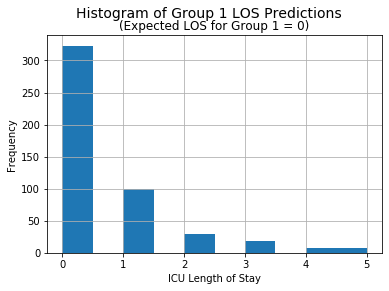

In [639]:
#group1 using model predictions
round(prediction_df_1['model_predictions']).hist()
plt.suptitle("Histogram of Group 1 LOS Predictions", fontsize=14)
plt.title("(Expected LOS for Group 1 = 0)", fontsize=12)
plt.xlabel("ICU Length of Stay", fontsize=10)
plt.ylabel("Frequency",fontsize=10)


Text(0, 0.5, 'Frequency')

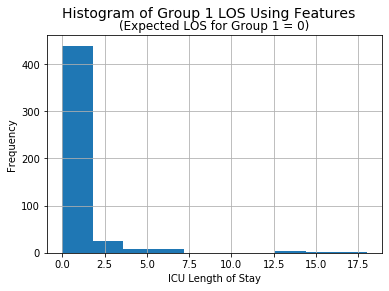

In [642]:
#group1 without predictions
group1_prediction_rows = group1_df.iloc[prediction_df_1.index]

group1_df_counts_df = group1_prediction_rows.groupby(['gender', 
                   'ethnicity_grouped', 
                   'admission_type',
                   'hospstay_seq', 
                   'first_hosp_stay',
                  'icustay_seq',
                   'first_icu_stay', 
                   'first_category', 
                   'blood', 
                   'circulatory',
                   'congenital', 
                   'digestive', 
                   'genitourinary', 
                   'ill-defined',
                   'infectious|parasitic', 
                   'injury|poisoning', 
                   'mental',
                   'metabolic|immunity', 
                   'musculoskeletal', 
                   'neoplasms', 
                   'nervous',
                   'perinatal', 
                   'respiratory', 
                   'skin', 
                   'unclassified', 
                   'FIRST_CAREUNIT', 
                  'age_group', 
                   'dod_exists', 
                   'sepsis',
                   'diagnoses_count', 
                   'INTIME_COLLAPSED_day']).sum()[['los_icu']]

#without model predictions we would need to groupby all these features to get the same information
group1_df_counts_df['los_icu'] = round(group1_df_counts_df['los_icu'])
group1_df_counts_df['los_icu'].hist()
plt.suptitle("Histogram of Group 1 LOS Using Features", fontsize=14)
plt.title("(Expected LOS for Group 1 = 0)", fontsize=12)
plt.xlabel("ICU Length of Stay", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

Text(0, 0.5, 'Frequency')

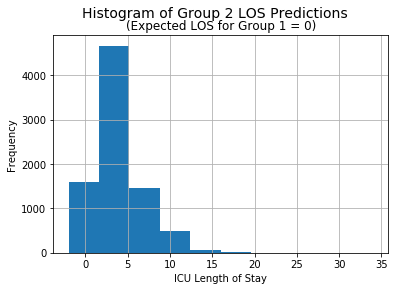

In [640]:
#group2 using model predictions
round(prediction_df_2['model_predictions']).hist()
plt.suptitle("Histogram of Group 2 LOS Predictions", fontsize=14)
plt.title("(Expected LOS for Group 1 = 0)", fontsize=12)
plt.xlabel("ICU Length of Stay", fontsize=10)
plt.ylabel("Frequency",fontsize=10)


Text(0, 0.5, 'Frequency')

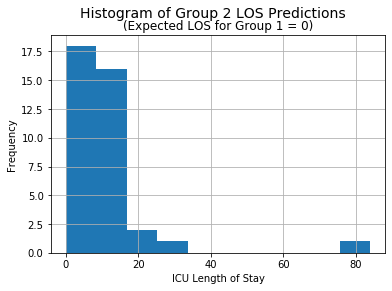

In [641]:
#group3 using model predictions
round(prediction_df_3['model_predictions']).hist()
plt.suptitle("Histogram of Group 2 LOS Predictions", fontsize=14)
plt.title("(Expected LOS for Group 1 = 0)", fontsize=12)
plt.xlabel("ICU Length of Stay", fontsize=10)
plt.ylabel("Frequency",fontsize=10)


Text(0.5, 0, 'Los Model Prediction')

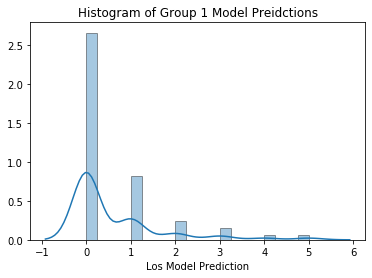

In [135]:
#Distribution for group 1  (0 days) #still some likelihood of los being other than 0
#using my model's predictions
sns.distplot(round(prediction_df_1['model_predictions']), hist=True, kde=True, hist_kws={'edgecolor':'black'})
plt.title('Histogram of Group 1 Model Preidctions')
plt.xlabel('Los Model Prediction')




Text(0.5, 0, 'Los Model Prediction')

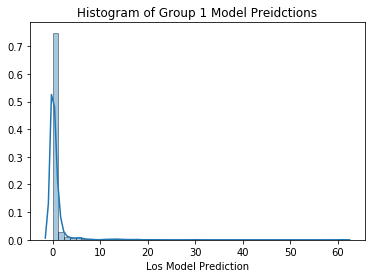

In [136]:
#comparing the plot to just raw data (not predictions)

sns.distplot(round(group1_df['los_icu']), hist=True, kde=True, hist_kws={'edgecolor':'black'})
plt.title('Histogram of Group 1 Model Preidctions')
plt.xlabel('Los Model Prediction')

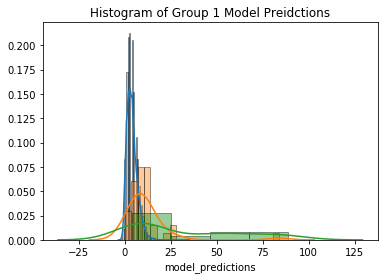

In [124]:
#distributions for groups 2, 3, and 4
sns.distplot(round(prediction_df_2['model_predictions']), hist=True, kde=True, hist_kws={'edgecolor':'black'})
sns.distplot(round(prediction_df_3['model_predictions']), hist=True, kde=True, hist_kws={'edgecolor':'black'})
plt.title('Histogram of Group 1 Model Preidctions')
plt.xlabel('Los Model Prediction')
sns.distplot(round(prediction_df_4['model_predictions']), hist=True, kde=True, hist_kws={'color': 'g', 'edgecolor':'black'})


# Compare to Validate Data

In [126]:
#validate data is split into each group
predicted_validate_1 = best_model_1.predict(X_validate_1)
r2_score(y_validate_1,predicted_validate_1) #negative r2 score means it's worse than using the mean

0.09598394362678331

In [127]:
predicted_validate_2 = best_model_2.predict(X_validate_2)
r2_score(y_validate_2,predicted_validate_2) 

0.11173163568738254

In [128]:
predicted_validate_3 = best_model_3.predict(X_validate_3)
r2_score(y_validate_3,predicted_validate_3) 

0.8360065608462665

In [129]:
predicted_validate_4 = model_4.predict(X_validate_4)
r2_score(y_validate_4,predicted_validate_4) 

0.6743596405615766

# Make distribution
We have a probability for los = 0-50 days, gor each gorup

In [285]:
counts_df = prediction_df_1['model_predictions'].value_counts()
counts_df

0.0    323
1.0     99
2.0     30
3.0     18
5.0      8
4.0      8
Name: model_predictions, dtype: int64

In [290]:
pd.DataFrame(counts_df/counts_df.sum()).reset_index().sort_values(by='index')

index  model_predictions
0    0.0           0.664609
1    1.0           0.203704
2    2.0           0.061728
3    3.0           0.037037
5    4.0           0.016461
4    5.0           0.016461

In [342]:
def to_distribution(group_df):
    counts_df = group_df['model_predictions'].value_counts()
    distribution_df = pd.DataFrame(counts_df/counts_df.sum()).reindex(range(0,50)).interpolate(method ='zero').fillna(0)
    distribution_df = distribution_df.rename(columns={'model_predictions': 'probability'})
    return distribution_df


In [345]:
def combine_distributions():
    df1 = to_distribution(prediction_df_1).rename(columns={'probability': 1})
    df2 = to_distribution(prediction_df_2).rename(columns={'probability': 2})
    df3 = to_distribution(prediction_df_3).rename(columns={'probability': 3})
    df4 = to_distribution(prediction_df_4).rename(columns={'probability': 4})
    return_df = pd.concat([df1, df2, df3, df4], axis=1)
    return return_df

In [346]:
combine_distributions()

1         2         3         4
0   0.664609  0.059841  0.026316  0.000000
1   0.203704  0.124609  0.026316  0.000000
2   0.061728  0.150204  0.026316  0.000000
3   0.037037  0.153329  0.052632  0.000000
4   0.016461  0.147921  0.078947  0.037736
5   0.016461  0.109589  0.026316  0.018868
6   0.000000  0.076544  0.105263  0.018868
7   0.000000  0.060082  0.105263  0.113208
8   0.000000  0.040014  0.052632  0.132075
9   0.000000  0.026196  0.026316  0.018868
10  0.000000  0.017424  0.078947  0.037736
11  0.000000  0.010214  0.105263  0.075472
12  0.000000  0.005528  0.078947  0.037736
13  0.000000  0.003725  0.078947  0.056604
14  0.000000  0.002043  0.052632  0.056604
15  0.000000  0.001562  0.052632  0.056604
16  0.000000  0.001562  0.052632  0.018868
17  0.000000  0.000360  0.052632  0.018868
18  0.000000  0.000360  0.052632  0.018868
19  0.000000  0.000360  0.052632  0.018868
20  0.000000  0.000120  0.052632  0.018868
21  0.000000  0.000120  0.052632  0.018868
22  0.000000  0.000120  0.052632  0.018868
23  0.000000  0.000120  0.052632  0.018868
24  0.000000  0.000120  0.026316  0.018868
25  0.000000  0.000120  0.026316  0.018868
26  0.000000  0.000120  0.026316  0.018868
27  0.000000  0.000120  0.026316  0.018868
28  0.000000  0.000120  0.000000  0.018868
29  0.000000  0.000120  0.000000  0.018868
30  0.000000  0.000120  0.000000  0.018868
31  0.000000  0.000120  0.000000  0.018868
32  0.000000  0.000120  0.000000  0.018868
33  0.000000  0.000120  0.000000  0.018868
34  0.000000  0.000120  0.000000  0.018868
35  0.000000  0.000000  0.000000  0.018868
36  0.000000  0.000000  0.000000  0.018868
37  0.000000  0.000000  0.000000  0.018868
38  0.000000  0.000000  0.000000  0.018868
39  0.000000  0.000000  0.000000  0.018868
40  0.000000  0.000000  0.000000  0.018868
41  0.000000  0.000000  0.000000  0.018868
42  0.000000  0.000000  0.000000  0.018868
43  0.000000  0.000000  0.000000  0.018868
44  0.000000  0.000000  0.000000  0.018868
45  0.000000  0.000000  0.000000  0.018868
46  0.000000  0.000000  0.000000  0.018868
47  0.000000  0.000000  0.000000  0.018868
48  0.000000  0.000000  0.000000  0.018868
49  0.000000  0.000000  0.000000  0.000000

In [354]:
los_probability_df = combine_distributions()

# Write to csv
as input to ABM




In [356]:
los_probability_df.to_csv('los_probability_df.csv', index=False)